<a href="https://colab.research.google.com/github/Spoiler-xl/climate-model/blob/main/climate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import joblib
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
climatedata=pd.read_csv(r"/content/drive/My Drive/qzvin_hourly_data.csv")
# Convert date to datetime and extract features
climatedata['date'] = pd.to_datetime(climatedata['date'])
climatedata['hour'] = climatedata['date'].dt.hour
climatedata['day'] = climatedata['date'].dt.day
climatedata['month'] = climatedata['date'].dt.month
climatedata['year'] = climatedata['date'].dt.year

#data preprocessing
print(climatedata.dtypes)
print(climatedata.head())
climatedata.isnull().sum()
climatedata.dropna(inplace=True)
climatedata.isnull().sum()
climate_daily= climatedata.copy()
climatedata.drop(columns=['date'], inplace=True)



date                                datetime64[ns, UTC]
temperature_2m                                  float64
relative_humidity_2m                            float64
dew_point_2m                                    float64
apparent_temperature                            float64
precipitation                                   float64
rain                                            float64
snowfall                                        float64
snow_depth                                      float64
weather_code                                      int64
pressure_msl                                    float64
surface_pressure                                float64
cloud_cover                                     float64
cloud_cover_low                                   int64
cloud_cover_mid                                   int64
cloud_cover_high                                  int64
et0_fao_evapotranspiration                      float64
vapour_pressure_deficit                         

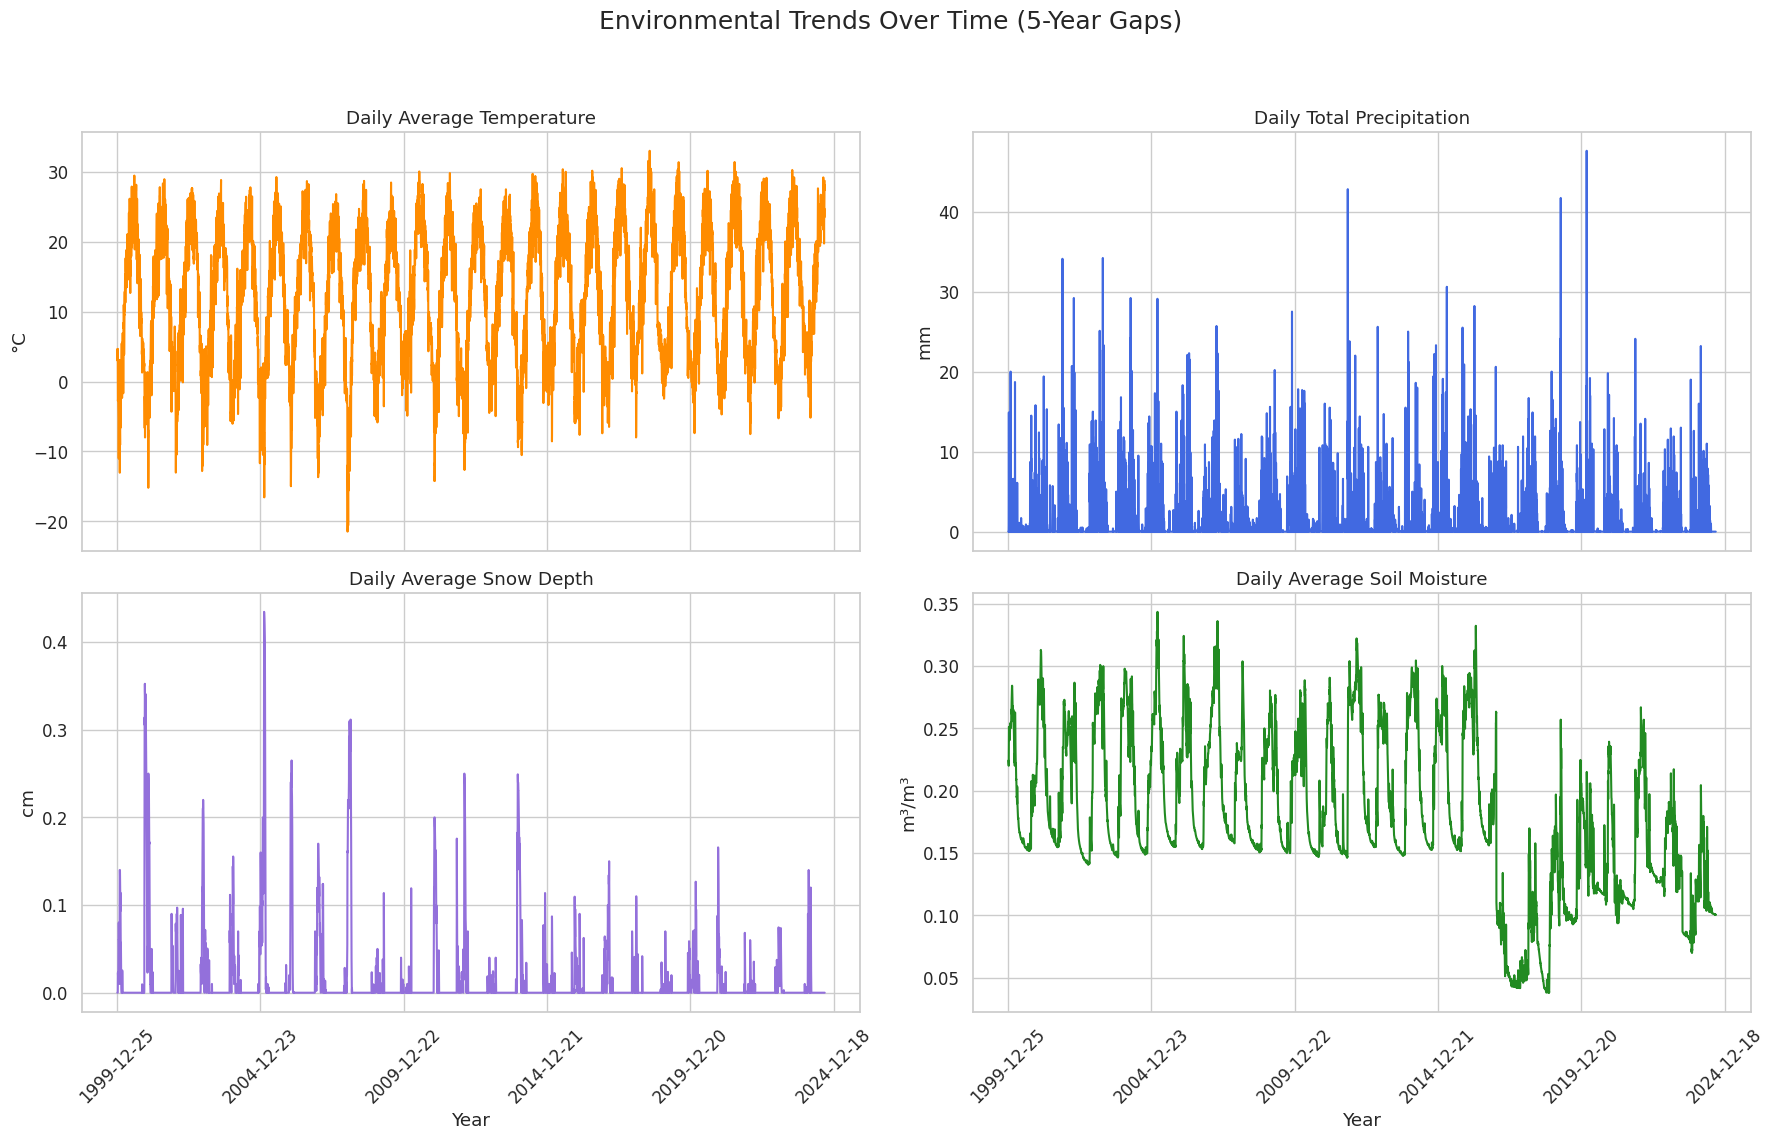

In [ ]:
daily_df = climate_daily.resample('D', on='date').agg({
    'temperature_2m': 'mean',
    'precipitation': 'sum',
    'snow_depth': 'mean',
    'soil_moisture_0_to_7cm': 'mean',
    'soil_moisture_7_to_28cm': 'mean',
    'soil_moisture_28_to_100cm': 'mean',
    'soil_moisture_100_to_255cm': 'mean'
})

# Average soil moisture across all layers
daily_df['avg_soil_moisture'] = daily_df[
    ['soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
     'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm']
].mean(axis=1)

# Set Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
fig.suptitle('Environmental Trends Over Time (5-Year Gaps)', fontsize=18)

# Plot Temperature
sns.lineplot(ax=axes[0, 0], x=daily_df.index, y=daily_df['temperature_2m'], color='darkorange')
axes[0, 0].set_title("Daily Average Temperature")
axes[0, 0].set_ylabel("°C")

# Plot Precipitation
sns.lineplot(ax=axes[0, 1], x=daily_df.index, y=daily_df['precipitation'], color='royalblue')
axes[0, 1].set_title("Daily Total Precipitation")
axes[0, 1].set_ylabel("mm")

# Plot Snow Depth
sns.lineplot(ax=axes[1, 0], x=daily_df.index, y=daily_df['snow_depth'], color='mediumpurple')
axes[1, 0].set_title("Daily Average Snow Depth")
axes[1, 0].set_ylabel("cm")

# Plot Soil Moisture
sns.lineplot(ax=axes[1, 1], x=daily_df.index, y=daily_df['avg_soil_moisture'], color='forestgreen')
axes[1, 1].set_title("Daily Average Soil Moisture")
axes[1, 1].set_ylabel("m³/m³")

# Set 5-year gaps on x-axis
for ax in axes.flat:
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(plt.MultipleLocator(365 * 5))  # approx every 5 years
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Define target variable (modify based on your goal)
target_variable = 'temperature_2m'

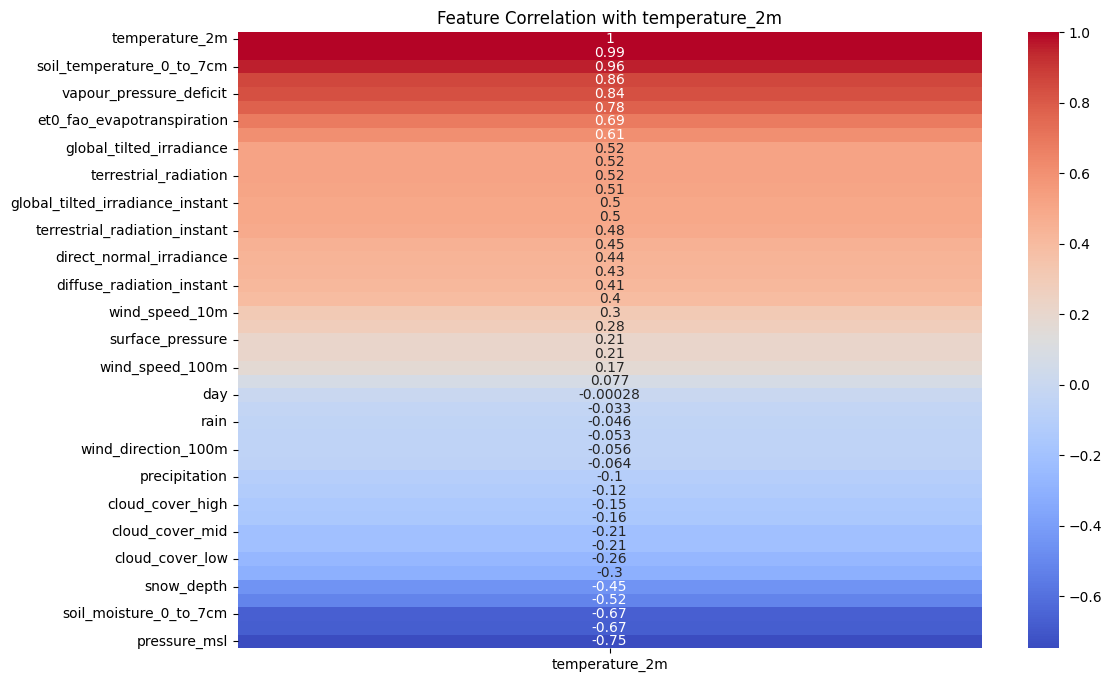

In [ ]:
# Compute correlation matrix
corr_matrix = climatedata.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False), annot=True, cmap='coolwarm')
plt.title(f'Feature Correlation with {target_variable}')
plt.show()

In [ ]:
correlated_features = corr_matrix[target_variable].abs().sort_values(ascending=False)
top_features = correlated_features.drop(target_variable).head(5)
selected_features = top_features.index.tolist()
print("Selected features:", selected_features)


Selected features: ['apparent_temperature', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'vapour_pressure_deficit', 'soil_temperature_28_to_100cm']


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
climatedata_scaled=scaler.fit_transform(climatedata)

In [ ]:
# Feature selection using Random Forest
X = climatedata[selected_features]
y = climatedata[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=selected_features)

In [ ]:
# Make Predictions
y_pred = rf.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.17574268367704263
R-squared: 0.9984742930316662


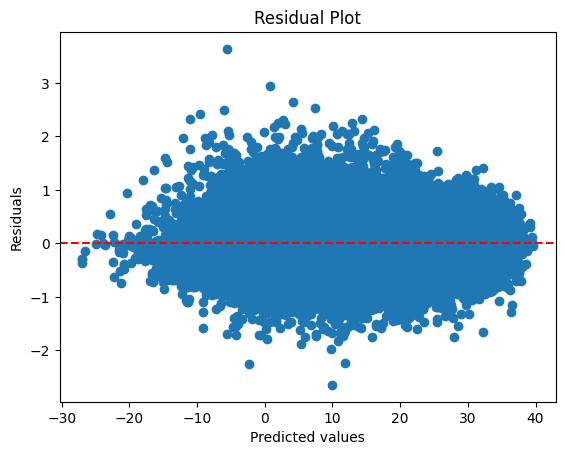

In [ ]:


residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression


# Model
model = LinearRegression()

# 5-Fold Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R-squared scores
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("R² Scores on each fold:", r2_scores)
print("Average R² Score:", np.mean(r2_scores))


R² Scores on each fold: [0.99275775 0.9927037  0.99272947 0.9926704  0.99268274]
Average R² Score: 0.9927088090842776


In [ ]:


# Negative MSE scores (scikit-learn uses negative MSE for scoring)
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_scores = -mse_scores

print("MSE on each fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))


MSE on each fold: [0.8342183  0.83071155 0.83561038 0.8419661  0.83620171]
Average MSE: 0.8357416080418212


In [ ]:
with gzip.open('rf.pkl.gz', 'wb') as file:
    joblib.dump(rf, file)